# 1. Dataset Overview

The dataset contains request logs of **sensei-server production** from `August 1, 2025` to `September 24, 2025`.

The dataset has `11283` entries and `38` columns.

**Step 0: Imports and Reading Data**

In [312]:
import math
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns

plt.rcParams['figure.dpi'] = 600
plt.rcParams['savefig.dpi'] = 600
pd.set_option('display.max_columns', 200)
df = pd.read_csv("./dataset/requests.csv")
# Normalize column names to snake_case
df.columns = (
    df.columns
    .str.strip()
    .str.replace(r'([a-z0-9])([A-Z])', r'\1_\2', regex=True)
    .str.replace(r'[^0-9a-zA-Z]+', '_', regex=True)
    .str.strip('_')
    .str.lower()
)

**Step 1: Data Understanding**


In [313]:
spec = pd.DataFrame(df.dtypes)
spec = spec.rename(columns={0: "dtype"})
spec["count"] = df.count()
spec["uniq_count"] = df.nunique()
spec["na_count"] = df.isnull().sum()
spec = spec.sort_values(by="dtype")
spec

,dtype,count,uniq_count,na_count
success,bool,11283,2,0
item_count,int64,11283,1,0
result_code,int64,11283,5,0
duration,int64,11283,5056,0
user_authenticated_id,float64,0,0,11283
application_version,float64,0,0,11283
user_account_id,float64,0,0,11283
user_id,float64,0,0,11283
session_id,float64,0,0,11283
client_state_or_province,float64,0,0,11283


**Inspect columns having unique count <= 1**

In [315]:
# create dictionary of columns having unique count = 1
unique_count_1_cols = spec[spec['uniq_count'] <= 1].index.tolist()
unique_count_1_dict = {col: df[col].iloc[0] for col in unique_count_1_cols}

# convert dictionary to dataframe
unique_count_1_df = pd.DataFrame(list(unique_count_1_dict.items()), columns=['column', 'value'])
unique_count_1_df

,column,value
0,item_count,1
1,cloud_role_name,prod-sensei-server
2,app_id,0950a19b-36f4-49b7-8869-44519ebfa1c0
3,app_name,/subscriptions/aad28fa9-e78e-4b8d-b9ab-3ef2a28...
4,i_key,a94a46af-5b59-42f0-a222-4906cc0ef61e
5,sdk_version,alm_py3.11.13:otel1.24.0:ext1.0.0b25
6,client_ip,0.0.0.0
7,operation_synthetic_source,NaN
8,item_type,request
9,client_os,#1 SMP PREEMPT_DYNAMIC Tue Jul 29 02:44:24 UTC...


In [261]:
print(df.client_type.unique())
print(df.client_model.unique())
print(df.client_browser.unique())

['PC' 'Bot']
['Other' nan 'Mac']
['Other' 'curl 8.11' 'Chrome 140.0' 'Chrome 139.0']


Drop not useful columns
- Having unique count <= 1
- Identifier columns like `operation_Id`, `operation_ParentId`, `id`, `itemId`
- `customDimensions`, `url` columns also not useful for analysis

In [316]:
df = df['timestamp_utc name duration result_code'.split()]


In [317]:
# aggregate data frame group by request_line
agg_df = df.groupby('name').agg(
    requests=('name', 'count'),
    errors=('result_code', lambda x: (x != 200).sum()),
    seconds=('duration', lambda x: math.ceil(np.sum(x) / 1000)),
    mean=('duration', lambda x: math.ceil(np.mean(x))),
    p25=('duration', lambda x: math.ceil(np.percentile(x, 25))),
    p50=('duration', lambda x: math.ceil(np.percentile(x, 55))),
    p75=('duration', lambda x: math.ceil(np.percentile(x, 75))),
    max=('duration', 'max'),
    cv=('duration', lambda x: round(np.std(x) / np.mean(x), 2)),
).reset_index()
agg_df = agg_df.sort_values(by='requests', ascending=False)
agg_df

,name,requests,errors,seconds,mean,p25,p50,p75,max,cv
16,POST /normal_v2/stream,5023,0,57653,11478,4191,7276,13207,680610,1.89
2,GET /chat_with_data/{job_id},2790,0,45,16,11,12,14,354,0.95
0,GET /,2297,0,12,5,3,4,6,99,0.87
11,POST /chat_with_data_v2/stream,476,7,14832,31160,12390,24948,38742,610499,1.20
10,POST /chat_with_data/file_list,206,0,82,394,176,277,405,4740,1.53
4,GET /mode/smes_modes,119,0,4,28,11,17,42,197,0.86
5,GET /multimodal/file_types/,81,0,1,4,3,3,3,29,0.93
1,GET /chat_with_data/file_types/,73,0,1,4,3,3,3,30,0.91
17,POST /web_search/stream,72,0,757,10507,7230,9442,12155,45719,0.58
12,POST /deep_search/stream,50,0,5343,106843,36270,51695,71417,1834960,2.41


/var/folders/6k/vbd2zfmn0f72hcxf2g5k6mm80000gp/T/ipykernel_87145/1486771868.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='requests', y='name', data=top_10_requests, palette=palette)


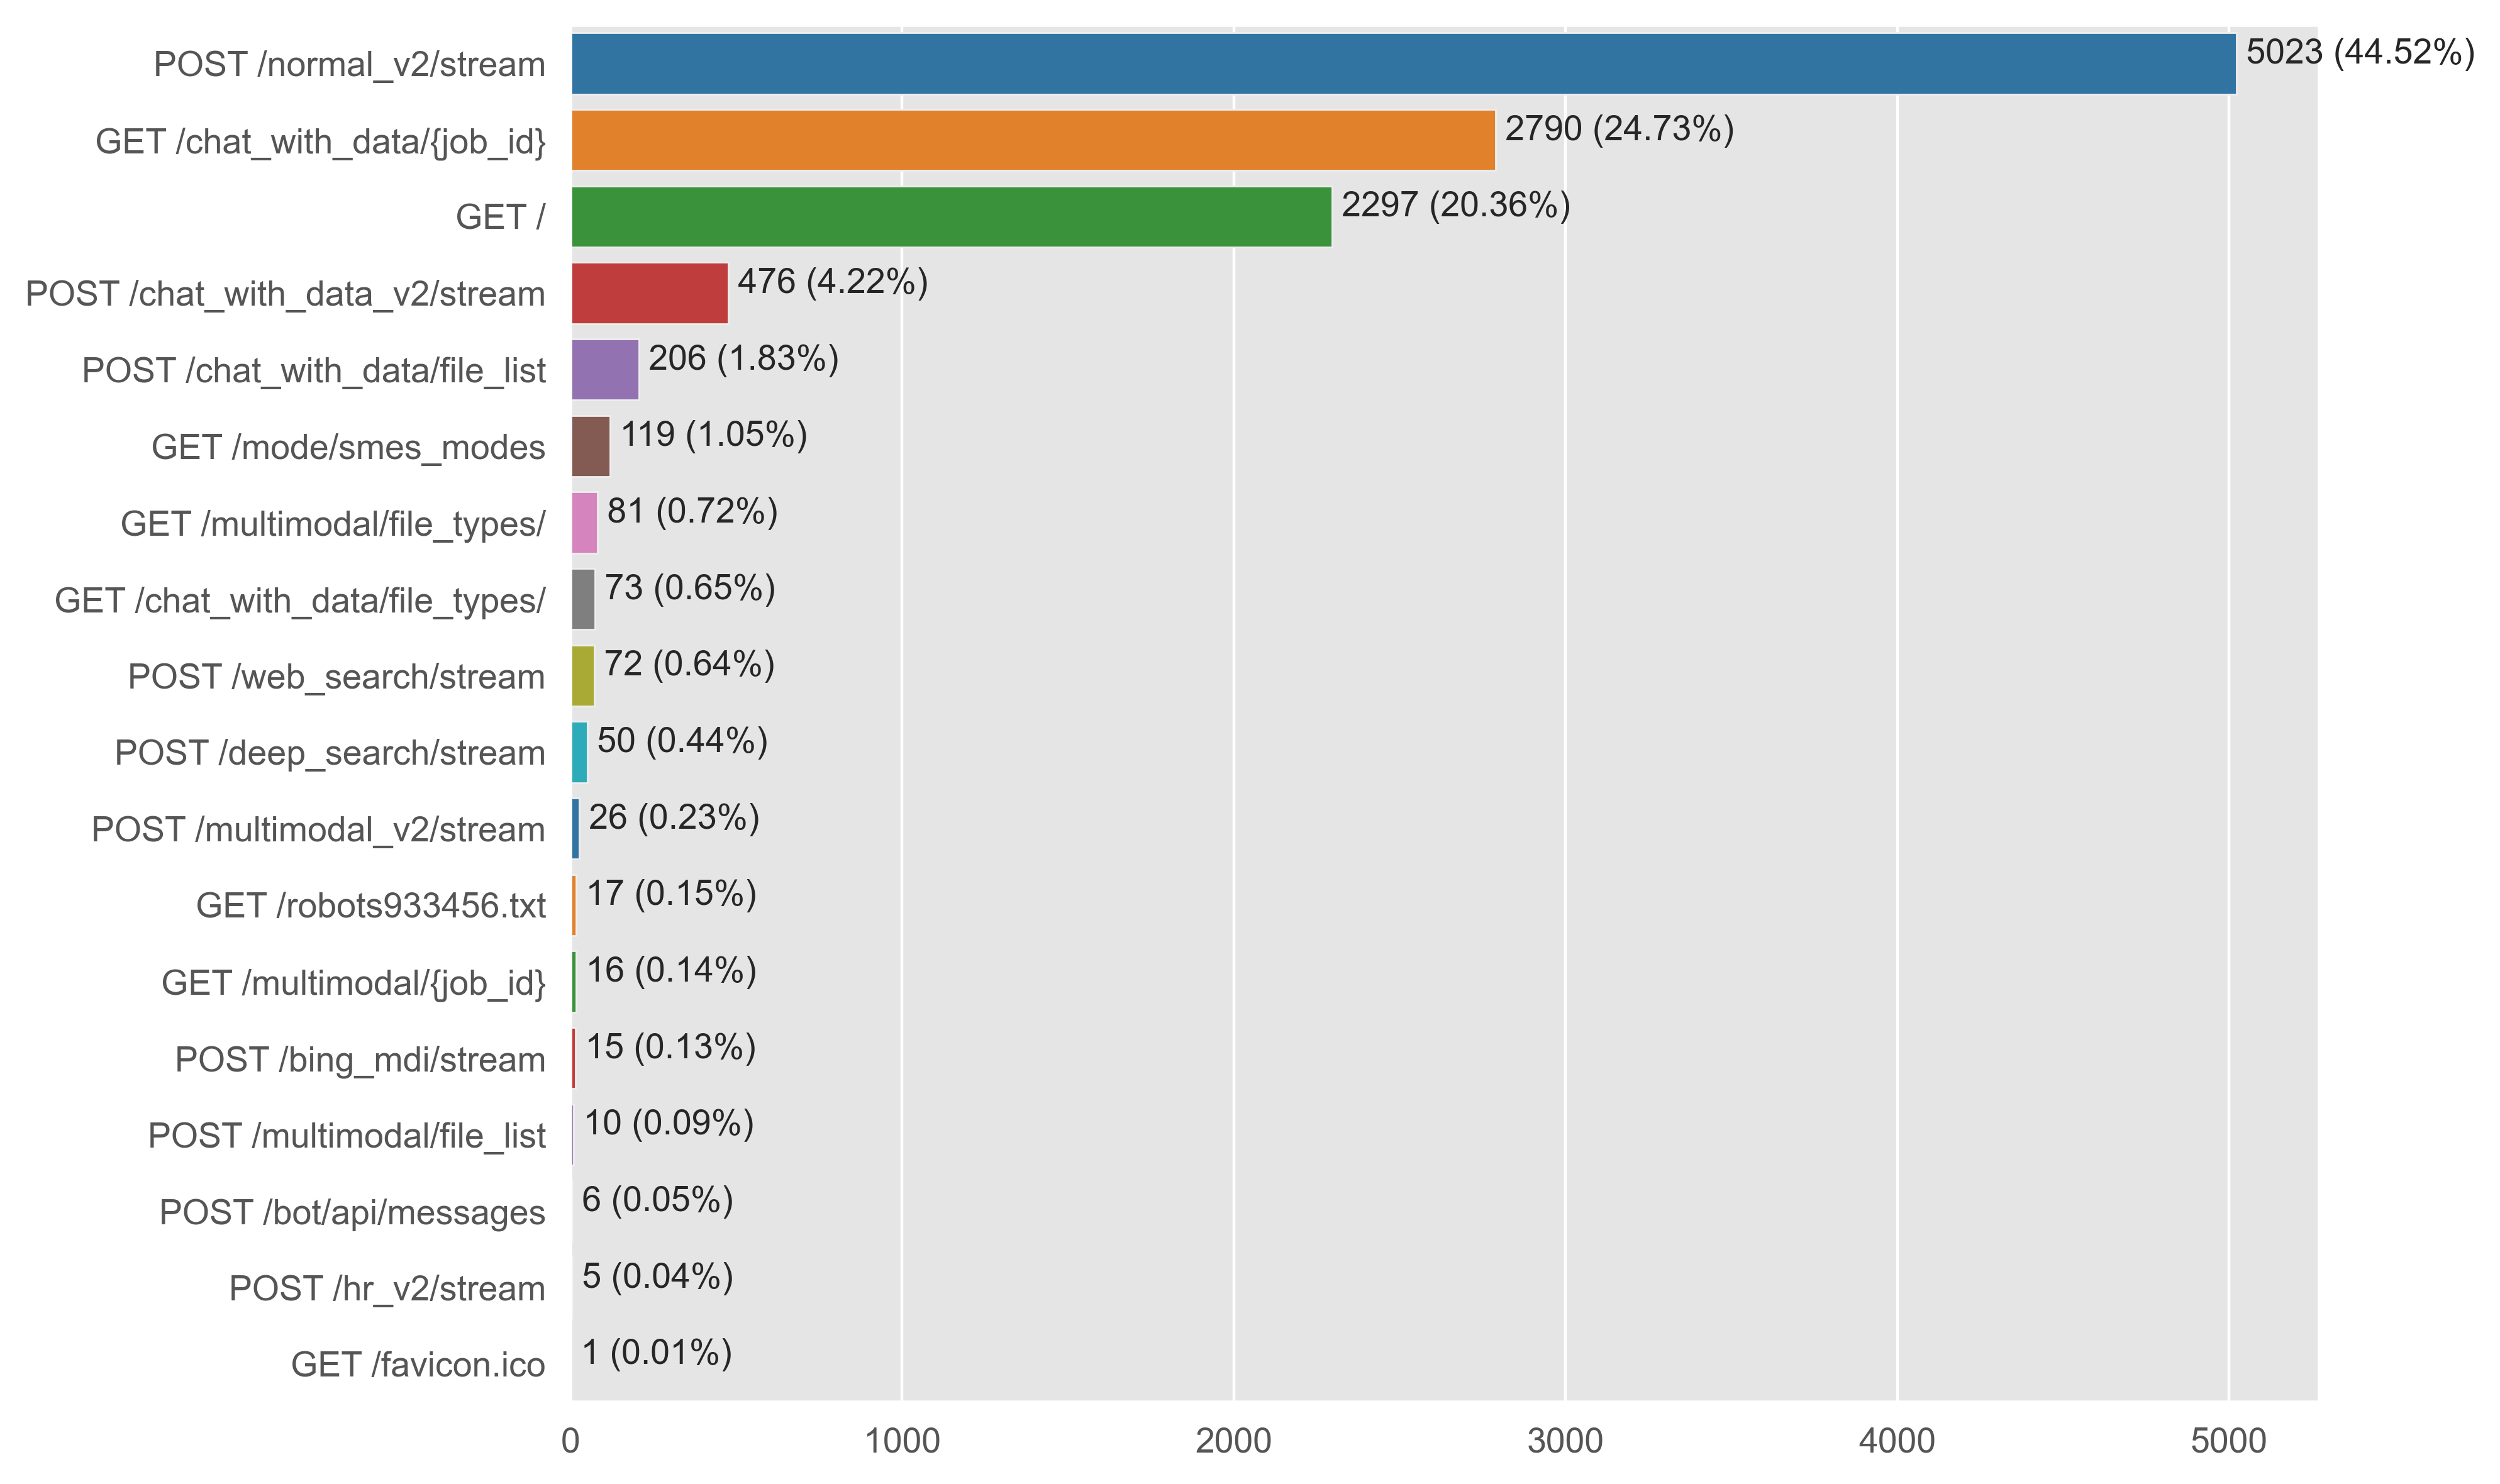

In [323]:
# plot requests by seconds with percent attached to bar
top_10_requests = agg_df.head(20).sort_values(by='requests', ascending=False)
top_10_requests['percent'] = round(top_10_requests['requests'] / top_10_requests['requests'].sum() * 100, 2)
plt.figure(figsize=(10, 6))
palette = sns.color_palette("tab10", n_colors=len(top_10_requests))
sns.barplot(x='requests', y='name', data=top_10_requests, palette=palette)
for index, value in enumerate(top_10_requests['requests']):
    plt.text(value, index, f' {value} ({top_10_requests["percent"].iloc[index]}%)')
plt.ylabel('')
plt.xlabel('')
plt.tight_layout()
plt.show()

/var/folders/6k/vbd2zfmn0f72hcxf2g5k6mm80000gp/T/ipykernel_87145/2717936697.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='seconds', y='name', data=top_10_requests, palette=palette)


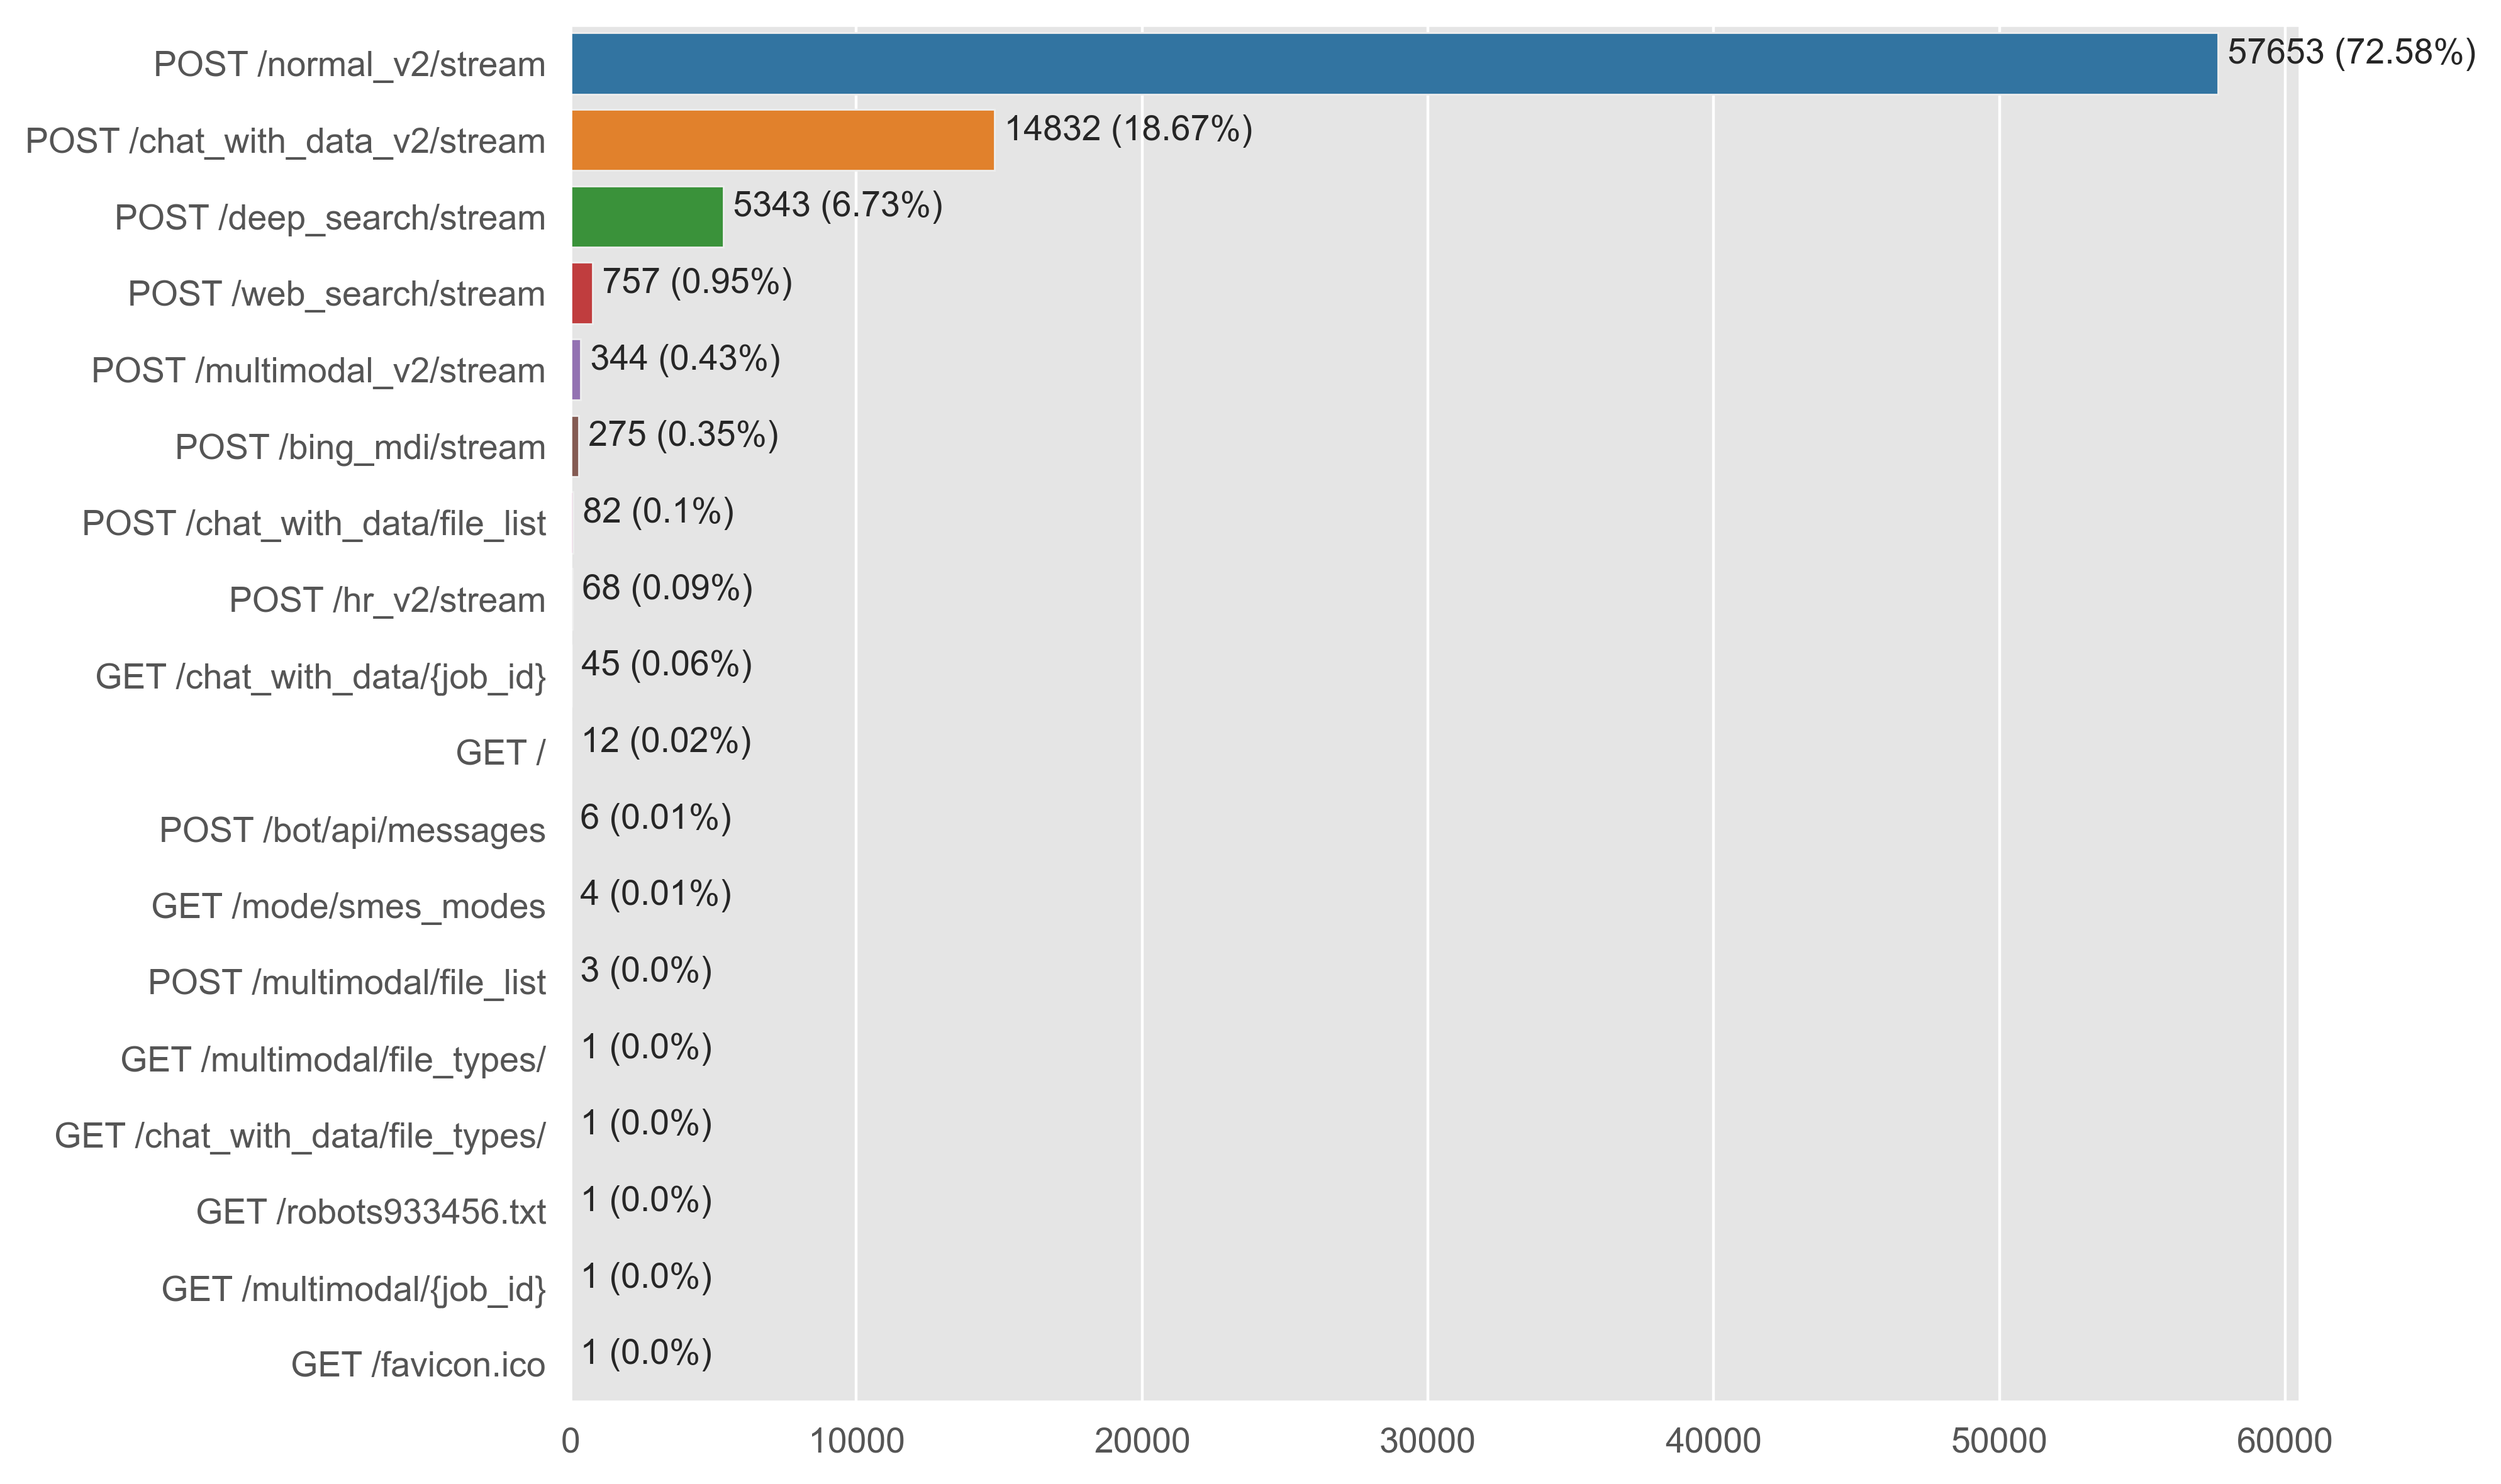

In [322]:
# plot requests by seconds with percent attached to bar
top_10_requests = agg_df.head(20).sort_values(by='seconds', ascending=False)
top_10_requests['percent'] = round(top_10_requests['seconds'] / top_10_requests['seconds'].sum() * 100, 2)
plt.figure(figsize=(10, 6))
palette = sns.color_palette("tab10", n_colors=len(top_10_requests))
sns.barplot(x='seconds', y='name', data=top_10_requests, palette=palette)
for index, value in enumerate(top_10_requests['seconds']):
    plt.text(value, index, f' {value} ({top_10_requests["percent"].iloc[index]}%)')
plt.ylabel('')
plt.xlabel('')
plt.tight_layout()
plt.show()